# Retirement Planner

---

## Environment Setup

In [6]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [7]:
# Set the random seed for resutls reproducibility (for testing purposes only)
np.random.seed(42)

---

## Portfolio Planner

In this activity, you will use the Alpaca API to grab historical data for a `60/40` portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [8]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
apca_api_key = os.getenv("APCA_API_KEY")
apca_secret_key = os.getenv("APCA_SECRET_KEY")

# Create the Alpaca API object
api = tradeapi.REST(
    apca_api_key,
    apca_secret_key,
    api_version = "v2")

# Data Collection

In this step, you will need to use the Alpaca api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [9]:
# Subset your tickers, then pull returns data:
# Set the ticker
ticker = ["SPY", "AGG"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp('2019-01-01', tz='America/New_York').isoformat()
end_date = pd.Timestamp('2019-12-31', tz='America/New_York').isoformat()

# Get 1 year's worth of historical data for SPY and AGG
ticker_df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

# Drop unnecessary columns
ticker_df = ticker_df.drop(columns=['open', 'high', 'low', 'volume'], level=1)

In [10]:
# Display sample data
ticker_df.head()

,AGG,SPY
,close,close
time,,
2019-01-02 00:00:00-05:00,106.585,249.89
2019-01-03 00:00:00-05:00,107.020,244.46
2019-01-04 00:00:00-05:00,106.695,252.41
2019-01-07 00:00:00-05:00,106.470,254.40
2019-01-08 00:00:00-05:00,106.420,256.65


---

## Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:

1. Calculate the daily returns for the SPY and AGG closing prices.

2. Calculate volatility for both the SPY and AGG closing prices.

3. Find the last day's closing price for both stocks and save those as variables

4. Run a Monte Carlo Simulation of at least `100` iterations and generate at least `30` years of closing prices

**Hint:** There are `252` trading days per year, so the number of records to generate for each Monte Carlo run will be `252 days * 30 years`.

In [11]:
# Calculate the daily roi for the stocks
daily_returns = ticker_df.pct_change()


avg_daily_return_agg = daily_returns.mean()["AGG"]["close"]
avg_daily_return_spy = daily_returns.mean()["SPY"]["close"]

#Display sample data

avg_daily_return_agg

0.00021276976507473064

In [12]:
# Compute daily volatility
std_dev_daily_return_agg = daily_returns.std()["AGG"]["close"]
std_dev_daily_return_spy = daily_returns.std()["SPY"]["close"]

print(std_dev_daily_return_agg)
print(std_dev_daily_return_spy)

0.0020886019741764646
0.007820053413439366


In [13]:
# Save the last day's closing price

last_day_close_spy = ticker_df['SPY']['close'][-1]
last_day_close_agg = ticker_df['AGG']['close'][-1]

In [14]:
# Setup the Monte Carlo Parameters
num_simulations = 500
num_records = 252 * 30
monte_carlo = pd.DataFrame()

simulated_price_df = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [15]:
# Run the Monte Carlo Simulation
for n in range(num_simulations):
    simulated_prices_agg = [last_day_close_agg]
    simulated_prices_spy = [last_day_close_spy]
    
    for i in range(num_records):
        simulated_price_agg = simulated_prices_agg[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        simulated_price_spy = simulated_prices_spy[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        
        simulated_prices_agg.append(simulated_price_agg)
        simulated_prices_spy.append(simulated_price_spy)

    simulated_price_df["AGG prices"] = pd.Series(simulated_prices_agg)
    simulated_price_df["SPY prices"] = pd.Series(simulated_prices_spy)
    
    simulated_daily_returns = simulated_price_df.pct_change()
    
    weights = [0.60, 0.40]
    
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    portfolio_cumulative_returns[n] = (1 + portfolio_daily_returns.fillna(0)).cumprod()
    

In [16]:
# Check that the simulation ran successfully
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000734,0.999712,0.998237,1.003406,1.008393,0.997498,0.999664,1.007943,1.000837,0.996925,...,1.001650,0.994703,1.002252,1.001714,0.997404,1.002493,1.000484,1.003432,0.999305,0.996260
2,1.006858,1.002968,1.001195,0.997723,1.007478,0.996020,0.996898,1.002470,1.000314,0.996704,...,1.004336,0.996975,1.003698,1.004215,0.998267,0.994751,1.001138,1.002625,0.997999,0.999466
3,1.006372,1.002684,1.001856,0.997835,1.006229,0.992280,1.000064,0.997846,1.000294,1.003229,...,1.004999,0.993501,1.004921,1.007249,0.994611,0.996294,1.005230,0.999495,1.000130,1.002152
4,1.011327,1.004633,1.004339,1.001542,1.010242,0.993665,1.003102,0.993692,1.002659,1.004777,...,1.003652,0.995610,1.005107,1.004128,0.996547,0.995422,1.002762,1.001599,0.999740,1.003183


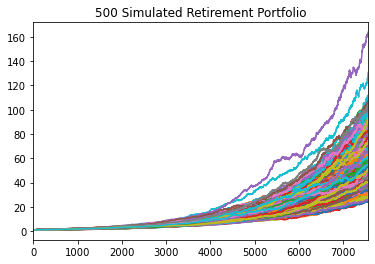

In [17]:
# Visualize the Simulation
plot_title = f"{n+1} Simulated Retirement Portfolio"
portfolio_cumulative_returns.plot(legend=None, title=plot_title)

In [18]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[252*20, :]
ending_cumulative_returns.tail()

495    24.030627
496    15.421765
497    25.273166
498    10.851077
499    16.295540
Name: 5040, dtype: float64

In [19]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

0.05    10.194368
0.95    21.797992
Name: 5040, dtype: float64

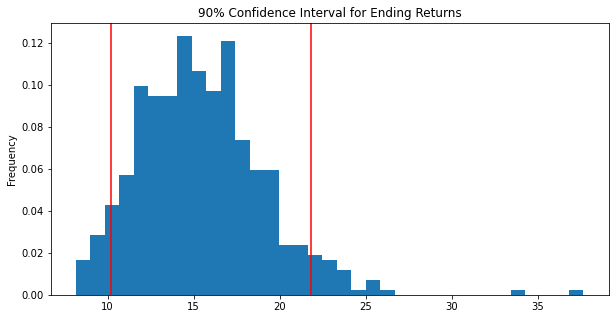

In [20]:
# Visualize the distribution of the ending returns

plt.figure();
ending_cumulative_returns.plot.hist(
    density=True,
    bins=35,
    figsize = (10,5),
    title = "90% Confidence Interval for Ending Returns")
plt.axvline(confidence_interval.iloc[0], color="r")
plt.axvline(confidence_interval.iloc[1], color="r")

---

## Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at `30` years for the `10th`, `50th`, and `90th` percentiles?

2. Given an initial investment of `$20,000`, what is the expected return in dollars at the `10th`, `50th`, and `90th` percentiles?

3. Given the current projected annual income from the Plaid analysis, will a `4%` withdrawal rate meet or exceed that value at the `10th` percentile? Note: This is basically determining if retirement income is equivalent to current income.

4. How would a `50%` increase in the initial investment amount affect the `4%` retirement withdrawal? In other words, what happens if the initial investment had been bigger?

###What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [21]:
ending_cumulative_returns = portfolio_cumulative_returns.iloc[252*30, :]
# Compute cumulative returns
print(f"Expected cumulative portfolio return at 30 years for the 10th percentile is {round(np.percentile(ending_cumulative_returns,10),2)}.")
print(f"Expected cumulative portfolio return at 30 years for the 50th percentile is {round(np.percentile(ending_cumulative_returns,50),2)}.")
print(f"Expected cumulative portfolio return at 30 years for the 90th percentile is {round(np.percentile(ending_cumulative_returns,90),2)}.")

Expected cumulative portfolio return at 30 years for the 10th percentile is 40.2.
Expected cumulative portfolio return at 30 years for the 50th percentile is 58.91.
Expected cumulative portfolio return at 30 years for the 90th percentile is 82.98.


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [28]:
# Set initial investment
initial_investment = 20000
cumulative_pnl = initial_investment * ending_cumulative_returns
# Compute expected portfolio return
print(f"Expected portfolio return in dollars at the 10th percentile is ${round(np.percentile(cumulative_pnl,10),2)}.")
print(f"Expected portfolio return in dollars at the 50th percentile is ${round(np.percentile(cumulative_pnl,50),2)}.")
print(f"Expected portfolio return in dollars at the 90th percentile is ${round(np.percentile(cumulative_pnl,90),2)}.")

Expected portfolio return in dollars at the 10th percentile is $803952.06.
Expected portfolio return in dollars at the 50th percentile is $1178287.29.
Expected portfolio return in dollars at the 90th percentile is $1659614.77.


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [29]:
# Set Plaid's projected income
# Calculate the 4% withdrawal for the ending return as retirement income
# Determine if the retirement income meets or exceeds the current projected income

projected_yearly_income=7389
withdraw = 0.04*(round(np.percentile(cumulative_pnl,10),2))

if withdraw >= projected_yearly_income:
    print("The 4% withdraw is equal or greater than the projected annual income")
else:
    print("The 4% withdraw is less than the projected annual income")
withdraw

The 4% withdraw is equal or greater than the projected annual income


32158.082400000003

### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [38]:
# Re-calculate the retirement income with a 50% increase in the initial investment amount

initial_investment_plus = 1.5*initial_investment
cumulative_pnl_plus = initial_investment_plus * ending_cumulative_returns
withdraw_plus = 0.04*(round(np.percentile(cumulative_pnl_plus,10),2))

projected_yearly_income = 7389

if withdraw_plus >= projected_yearly_income:
    print("The 4% withdraw is equal or greater than the projected annual income")
else:
    print("The 4% withdraw is less than the projected annual income")

new_withdraw = withdraw_plus - withdraw
print(new_withdraw)    
difference_increase_investment_by_50pct = initial_investment_plus - initial_investment
print(difference_increase_investment_by_50pct)

The 4% withdraw is equal or greater than the projected annual income
16079.0416
10000.0


### Optional Challenge

Use the Monte Carlo data and calculate the cumulative returns at the `5%`, `50%`, and `95%` quartiles and plot this data as a line chart to see how the cumulative returns change over the life of the investment.

In this section, you need to calculate and plot the cumulative returns for the median and `90%` confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# Compute projected returns
# Display sample data

for x in range(num_records):
    proj_returns = simulated_daily_returns[-1]*(simulated_daily_returns.quantile([.05,.5,.95]))  

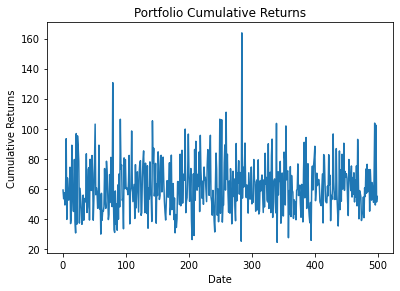

In [40]:
# Plot the cumulative returns over time


In [ ]:
# Compute portfolio performance over time

# Plot projected performance over time
